In [1]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from numba import jit
from scipy.linalg import hadamard
from scipy import linalg
from sklearn.utils import extmath
from scipy.misc import toimage
import cv2
from PIL import Image

# Matrix multuplication

In [13]:
#calculate probability
def max_fnorm(A,B):
    fnorms=np.zeros(A.shape[1])
    nsum=0
    for i in range(A.shape[1]):
        fnorm=np.linalg.norm(A[:,i]) * np.linalg.norm(B[i,:])
        fnorms[i]=fnorm
        nsum=nsum+fnorm
    return fnorms/nsum

In [14]:
#random matrix multiplication
def rand_matrix_mul(A,B,c,probability):
    col=np.array(range(A.shape[1]))
    msum=np.zeros([A.shape[0],B.shape[1]])
    for i in range(c):
        j=np.random.choice(col,p=probability)
        Aj=np.reshape(A[:,j],[len(A[:,j]),1])
        Bj=np.reshape(B[j,:],[1,len(B[j,:])])
        mul=np.matmul(Aj,Bj)/(c*p[j])
        msum=msum+mul
    return msum

In [15]:
#create random array
A = np.random.rand(1000,100000)
B = np.random.rand(100000,1000)
C = np.array(range(50,501,50))
times=np.zeros(len(C))
errors=np.zeros(len(C))

#calculate the exact matrix multiplication
start=time.time()
exact=np.matmul(A,B)
end=time.time()
print("exact time used: ",end-start)
extfnorm=np.linalg.norm(exact)
print('exact norm: ',extfnorm*extfnorm)

#get the probability
p=max_fnorm(A,B)
#calculate the random matrix multiplication
index=0
for c in C:
    timS = np.zeros(70)
    errS = np.zeros(70)
    for i in range(70):
        start=time.time()
        random=rand_matrix_mul(A,B,c,p)
        end=time.time()
        error=np.linalg.norm(exact-random)
        timS[i] = end-start
        errS = error*error/(extfnorm*extfnorm)
    times[index]=np.average(timS)
    errors[index]=np.average(errS)
    index+=1

exact time used:  9.710940837860107
exact norm:  625019770337167.9


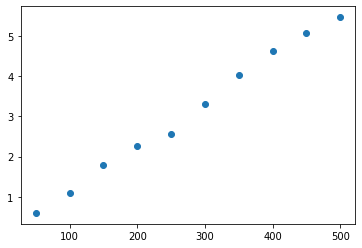

In [16]:
plt.scatter(C,times)
#plt.scatter(C,errors)

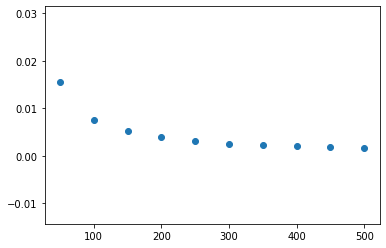

In [17]:
plt.scatter(C,errors)

# Low rank matrix approximation

In [6]:
def hadamardM(H,n,index):
    if index==n:
        return H
    if index==1:
        H[0,0]=1
        H[0,1]=1
        H[1,0]=1
        H[1,1]=-1
    else:
        H[0:index,index:index+index]=H[0:index,0:index]
        H[index:index+index,0:index]=H[0:index,0:index]
        H[index:index+index,index:index+index]=H[0:index,0:index]*(-1)
    index=2*index
    return hadamardM(H,n,index)

In [7]:
def low_rank_matrix(A,k):
    #calculating c with c0=1 and e=0.25
    n=A.shape[1]
    co=0.01
    c=int(co*k*math.log(n)*(math.log(k/0.0625)+math.log(math.log(n)))/0.0625)+2
    H=hadamard(n)/math.sqrt(n)
    C=range(n)
    chosen=np.random.choice(C,size=c)
    D=np.zeros([n,n])
    for i in range(n):
        D[i,i]=np.random.choice([1,-1])
    AD=np.matmul(A,D)
    approx=np.zeros([A.shape[0],c])
    for i in range(c):
        approx[:,i]=np.matmul(AD,H[:,chosen[i]])
    base=linalg.orth(approx)
    W=np.matmul(np.matrix.transpose(base),A)
    leftW=np.linalg.svd(W)[0][:,0:k]
    approximation=np.matmul(base,leftW)
    return approximation

In [100]:
def rsvd(A,k):
    IA=A
    #IA=np.matmul(np.matmul(IA,np.matrix.transpose(IA)),IA)
    #row_sums = IA.sum(axis=1)
    #IA = IA / row_sums[:, np.newaxis]
    omega=np.random.rand(IA.shape[1],k)
    Q,R=np.linalg.qr(np.matmul(IA,omega))
    S,sigma,Vt=np.linalg.svd(np.matmul(np.matrix.transpose(Q),IA))
    return np.matmul(Q,S),sigma,Vt[0:k,:]

In [70]:
#creating A
A=np.random.rand(4096,4096)

In [41]:
#randomized low rank matrix approximation
start=time.time()
resultR=low_rank_matrix(A,10)
end=time.time()
print(end-start)

7.498075246810913


In [90]:
#randomized svd by myself
start=time.time()
resultSRU,resultSRS,resultSRVT=rsvd(A,10)
end=time.time()
print(end-start)

1.7422900199890137


In [22]:
#exact SVD
start=time.time()
resultE=np.linalg.svd(A)
end=time.time()
print(end-start)

54.56694674491882


In [91]:
#randomized SVD
start=time.time()
resultS=extmath.randomized_svd(A,10)
end=time.time()
print(end-start)

1.105997085571289


In [114]:
timeM=np.zeros(10)
timeS=np.zeros(10)
timeR=np.zeros(10)
accuracyM=np.zeros(10)
accuracyS=np.zeros(10)
accuracyR=np.zeros(10)

K=np.arange(10,101,10)
index=0
norm=np.linalg.norm(A)
for k in K:
    #for mine
    start=time.time()
    resultSRU,resultSRS,resultSRVT=rsvd(A,k)
    end=time.time()
    timeM[index]=end-start
    v=len(resultSRS)
    V=np.zeros([v,v])
    for i in range(v):
        V[i,i]=resultSRS[i]
    accuracyM[index]=abs(np.linalg.norm(np.matmul(np.matmul(resultSRU,V),resultSRVT))-norm)
    
    #for rsvd
    start=time.time()
    resultS=extmath.randomized_svd(A,k)
    end=time.time()
    timeS[index]=end-start
    v=len(resultS[1])
    V=np.zeros([v,v])
    for i in range(v):
        V[i,i]=resultS[1][i]
    accuracyS[index]=abs(np.linalg.norm(np.matmul(np.matmul(resultS[0],V),resultS[2]))-norm)
    
    #for low rank approx
    start=time.time()
    resultR=low_rank_matrix(A,k)
    end=time.time()
    timeR[index]=end-start
    #accuracyR[index]=abs(np.linalg.norm(np.matmul(np.matmul(resultR,np.matrix.transpose(resultR)),A))-norm)
    accuracyR[index]=abs(np.linalg.norm(np.matmul(np.matmul(resultR,np.matrix.transpose(resultR)),A)))

    
    index+=1

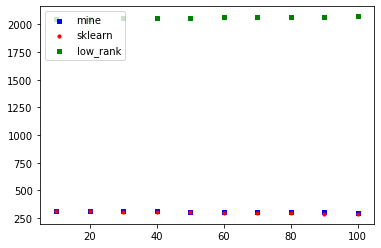

'\nX = accuracyM\nY = accuracyS\nfig2 = plt.figure()\nax2 = fig.add_subplot(111)\n\nax2.scatter(X, K, s=10, c=\'b\', marker="s", label=\'mine\')\nax2.scatter(Y,K, s=10, c=\'r\', marker="o", label=\'sklearn\')\nplt.legend(loc=\'upper left\');\nplt.show()\n'

In [122]:
accuracyRC=abs(accuracyR-norm)
x = accuracyM
y = accuracyS
z = accuracyRC
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(K,x, s=10, c='b', marker="s", label='mine')
ax1.scatter(K,y, s=10, c='r', marker="o", label='sklearn')
ax1.scatter(K,z, s=10, c='g', marker="s", label='low_rank')
plt.legend(loc='upper left');
plt.show()

In [123]:
print(accuracyR)

[319.36529001 314.49332531 311.22339504 308.51326734 305.84387916
 303.07121231 300.37766422 297.65172752 294.88484365 292.12429398]


In [45]:
#norm of approximation from rand low rank matrix approximation
print(np.linalg.norm(np.matmul(np.matmul(resultR,np.matrix.transpose(resultR)),A)))

2046.4941259646664


In [72]:
#norm of approximation from rsvd from myself
v=len(resultSRS)
V=np.zeros([v,v])
for i in range(v):
    V[i,i]=resultSRS[i]
print(np.linalg.norm(np.matmul(np.matmul(resultSRU,V),resultSRVT)))

1.000041288512951


In [46]:
#norm of approximation from rsvd
v=len(resultS[1])
V=np.zeros([v,v])
for i in range(v):
    V[i,i]=resultS[1][i]
print(np.linalg.norm(np.matmul(np.matmul(resultS[0],V),resultS[2])))

2050.9846793488846


In [47]:
#image
im=cv2.imread("test.JPG")
R=im[0:512,0:512,0]
G=im[0:512,0:512,1]
B=im[0:512,0:512,2]

#randomized low rank matrix approximation
start=time.time()
R_R=low_rank_matrix(R,50)
rR_R=np.matmul(np.matmul(R_R,np.matrix.transpose(R_R)),R)
G_R=low_rank_matrix(G,50)
rG_R=np.matmul(np.matmul(G_R,np.matrix.transpose(G_R)),G)
B_R=low_rank_matrix(B,50)
rB_R=np.matmul(np.matmul(B_R,np.matrix.transpose(B_R)),B)
end=time.time()
print(end-start)

rgb_R=np.zeros([512,512,3])
rgb_R[:,:,0]=rR_R
rgb_R[:,:,1]=rG_R
rgb_R[:,:,2]=rB_R
toimage(rgb_R).show()


1.1100890636444092


/Users/lihaoyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


In [73]:
#randomized SVD from myself
start=time.time()
R_S=rsvd(R,50)
G_S=rsvd(G,50)
B_S=rsvd(B,50)
end=time.time()
print(end-start)

v=len(R_S[1])
V=np.zeros([v,v])
for i in range(v):
    V[i,i]=R_S[1][i]
resultRed=np.matmul(np.matmul(R_S[0],V),R_S[2])

v=len(G_S[1])
V=np.zeros([v,v])
for i in range(v):
    V[i,i]=G_S[1][i]
resultGre=np.matmul(np.matmul(G_S[0],V),G_S[2])

v=len(B_S[1])
V=np.zeros([v,v])
for i in range(v):
    V[i,i]=B_S[1][i]
resultBlu=np.matmul(np.matmul(B_S[0],V),B_S[2])

rgb_S=np.zeros([512,512,3])
rgb_S[:,:,0]=resultRed
rgb_S[:,:,1]=resultGre
rgb_S[:,:,2]=resultBlu
toimage(rgb_S).show()

1.1157619953155518


/Users/lihaoyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


In [50]:
#randomized SVD
start=time.time()
R_S=extmath.randomized_svd(R,10)
G_S=extmath.randomized_svd(G,10)
B_S=extmath.randomized_svd(B,10)
end=time.time()
print(end-start)

v=len(R_S[1])
V=np.zeros([v,v])
for i in range(v):
    V[i,i]=R_S[1][i]
resultRed=np.matmul(np.matmul(R_S[0],V),R_S[2])

v=len(G_S[1])
V=np.zeros([v,v])
for i in range(v):
    V[i,i]=G_S[1][i]
resultGre=np.matmul(np.matmul(G_S[0],V),G_S[2])

v=len(B_S[1])
V=np.zeros([v,v])
for i in range(v):
    V[i,i]=B_S[1][i]
resultBlu=np.matmul(np.matmul(B_S[0],V),B_S[2])

rgb_S=np.zeros([512,512,3])
rgb_S[:,:,0]=resultRed
rgb_S[:,:,1]=resultGre
rgb_S[:,:,2]=resultBlu
toimage(rgb_S).show()

0.13844895362854004


/Users/lihaoyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


# Randomized Least Square

In [ ]:
def rls(A,b,epslon):
    n=A.shape[0]
    d=A.shape[1]
    #get r
    r1=48*48*d*math.log(40*n*d)*math.log(10000*d*math.log(40*n*d))
    r2=40*d*math.log(40*n*d)/epslon
    r=max(r1,r2)
    #get H
    H=hadamard(n)/math.sqrt(n)
    #choose r columns
    N=range(n)
    chosen=np.random.choice(N,size=r)
    #get D
    D=np.zeros([n,n])
    for i in range(n):
        D[i,i]=np.random.choice([1,-1])
    HDA=np.matmul(H,np.matmul(D,A))
    HDb=np.matmul(H,np.matmul(D,b))
    

In [127]:
n=100000000
d=20
epslon=0.01
print(48*48*d*math.log(40*n*d)*math.log(10000*d*math.log(40*n*d)))
print(40*d*math.log(40*n*d)/epslon)

17849242.672132708
2008423.3977296234


In [88]:
d*math.log(d)*math.log(n)+d*math.log(n)/epslon

57657.274018482894

# Low Rank Approximation for PSD

In [8]:
from numpy.linalg import matrix_rank
from numpy.linalg import inv
from scipy.linalg import eigh
from numpy import fft
from numpy.linalg import pinv


In [9]:
#low rank approximation for SPSD with sketches
def get_u(A):
    k = matrix_rank(A)
    projection = np.matmul(np.matmul(A,inv(np.matmul(A.transpose(),A))),A.transpose())
    max = projection[0,0]
    for i in range(projection.shape[0]):
        if projection[i,i]>max:
            max = projection[i,i]
    n = A.shape[0]
    u = n/k*max
    return u
    
def get_l_ny(u,k,epslon,delta,inc):
    min_l = 2*u*(1/(epslon*epslon))*k*math.log(k/delta)
    return math.ceil(min_l + inc)

def get_l_gs(k,epslon):
    return math.ceil((1+epslon*epslon)*k)
    
def nystrom(n,l):
    I = np.identity(n)
    choice = np.random.choice(n, size=l, replace=False)
    S = I[:,choice]
    return S

def srft(n,l):
    D=np.zeros([n,n])
    for i in range(n):
        D[i,i]=np.random.choice([1,-1])
    DF = fft.rfft2(D,norm="ortho")
    S = nystrom(n,l)
    print(DF.shape)
    DFR = np.matmul(DF,S)
    return np.sqrt(n/l)*DFR

def gaussian(n,l):
    return np.random.normal(size=(n,l))

def approximation(A,l,extension):
    if extension == 0:
        S = nystrom(A.shape[0],l)
    elif extension == 1:
        S = srft(A.shape[0],l)
    elif extension == 2:
        S = gaussian(A.shape[0],l)
    C = np.matmul(A,S)
    W = np.matmul(S.transpose(),np.matmul(A,S))
    Winv = pinv(W)
    approx = np.matmul(C,np.matmul(Winv,C.transpose()))
    return approx

In [10]:
old_A=np.random.rand(5000,5000)
A = np.matmul(old_A,old_A.transpose())
u=get_u(A)

In [71]:
n=old_A.shape[0]
I = np.identity(n)
choice = np.random.choice(n, size=10, replace=False)
I[:,choice] = I[:,choice]*1000
A_100 = np.matmul(old_A,I)
newA = np.matmul(A_100,A_100.transpose())
new_U=get_u(newA)

In [18]:
#This part of code has some bug I have not noticed before and I am working on solving it.
#nystrom
inputM = A
inputU = u
N = 10
epslon = 0.9
normA = np.linalg.norm(inputM)
timeN = np.zeros(N)
accuracyN = np.zeros(N)
timeG = np.zeros(N)
accuracyG = np.zeros(N)
K = np.zeros(N)
for i in range(N):
    k = i*10+10
    
    l=get_l_ny(inputU,k,epslon,0.9,0)
    l=l*2
    accN = np.zeros(5)
    tmN = np.zeros(5)
    for j in range(5):
        startN = time.time()
        Aapprox0 = approximation(inputM,l,0)
        endN = time.time()
        tmN[j] = endN-startN
        accN[j] = normA-np.linalg.norm(Aapprox0)
    #print(l)
    
    
    l=get_l_gs(k,epslon)
    l = l*2
    accG = np.zeros(5)
    tmG = np.zeros(5)
    for m in range(5):
        startG = time.time()
        Aapprox1 = approximation(inputM,l,2)
        endG = time.time()
        tmG[j] = endG-startG
        accG[j] = normA-np.linalg.norm(Aapprox1)
    print(l)
    print("***")
    
    timeN[i] = np.average(tmN)
    timeG[i] = np.average(tmG)
    K[i] = k
    accuracyN[i] = np.average(accN)
    accuracyG[i] = np.average(accG)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1000 is different from 100000)

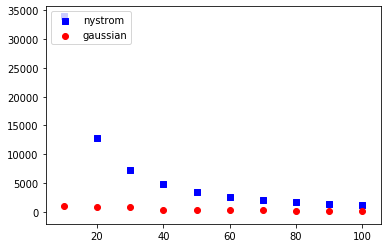

6251772.593499592


In [6]:
x = accuracyN
y = accuracyG
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(K,x, c='b', marker="s", label='nystrom')
ax1.scatter(K,y, c='r', marker="o", label='gaussian')
plt.legend(loc='upper left');
plt.show()
print(normA)

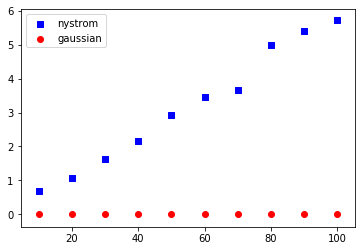

In [9]:
a = timeN
b = timeG
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(K,a, c='b', marker="s", label='nystrom')
ax1.scatter(K,b, c='r', marker="o", label='gaussian')
plt.legend(loc='upper left');
plt.show()

In [79]:
print(x)
print(y)

[1.20448164e-06 4.31021908e-07 2.26444443e-07 1.34756378e-07
 8.83928334e-08 5.64180630e-08 3.68166252e-08 2.33858440e-08
 1.58408896e-08 1.00081633e-08]
[7.28840279e-05 8.98336418e-06 6.62651299e-06 3.43850757e-06
 2.09157921e-06 1.96807809e-06 2.02194980e-06 1.41169529e-06
 1.28724437e-06 1.17978229e-06]


In [80]:
for i in range(N):
    k = i*10+10
    l=get_l_gs(k,epslon)
    print(l)

19
37
55
73
91
109
127
145
163
181


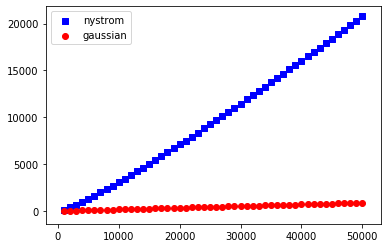

In [98]:
M = 50
lN = np.zeros(M)
lG = np.zeros(M)
KK = np.zeros(M)
for i in range(M):
    n = i*1000+1000
    k = n/100
    lN[i]=get_l_ny(inputU,k,epslon,0.9,0)
    lG[i]=get_l_gs(k,epslon)
    KK[i]=n
a = lN
b = lG
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(KK,a, c='b', marker="s", label='nystrom')
ax1.scatter(KK,b, c='r', marker="o", label='gaussian')
plt.legend(loc='upper left');
plt.show()

In [7]:
print(y)

[1006.73343466  796.31672124  865.85164265  345.2422611   295.90506394
  311.35206282  244.88951203  205.31612218  186.27932811  138.05777498]


In [10]:
print(b)

[0.00524897 0.00638347 0.00735998 0.00897117 0.01311699 0.00722676
 0.00934746 0.01131947 0.0124033  0.0129519 ]


In [11]:
print(x)

[33954.89298873 12852.44050778  7272.75701482  4847.15796093
  3495.40129615  2662.47501322  2080.0322305   1670.23442038
  1360.59779655  1121.73392249]


In [12]:
print(a)

[0.69489672 1.08272074 1.6348556  2.16348006 2.93796542 3.45258002
 3.67053808 4.98939208 5.38446053 5.72975942]


In [5]:
A = np.zeros(10)+1
A = np.reshape(A,[2,5])*2

A

array([[2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2.]])

In [6]:
np.linalg.norm(A)

6.324555320336759

In [11]:
u

1.0027364287039662